In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

%matplotlib inline


In [220]:
raw_data = pd.read_csv('../../data/credit_card_data.csv')
raw_data.head()


,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [221]:
data = raw_data.copy()
data['card'] = (data.card == 'yes').astype('int')

In [222]:
data.isna().value_counts()

card   reports  age    income  share  expenditure  owner  selfemp  dependents  months  majorcards  active
False  False    False  False   False  False        False  False    False       False   False       False     1319
dtype: int64

In [223]:
data.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [224]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']


In [225]:
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]
categorical = ["owner", "selfemp"]

In [226]:
scores = []
for n in numerical:
  score = roc_auc_score(y_train, df_train[n])
  scores.append((n, score))

scores

[('reports', 0.28333701393106236),
 ('age', 0.4759979020592945),
 ('income', 0.5908049467233478),
 ('share', 0.989183643423692),
 ('expenditure', 0.991042345276873),
 ('dependents', 0.46722427722262094),
 ('months', 0.470578221903237),
 ('majorcards', 0.5343859842838476),
 ('active', 0.6043173411362006)]

In [227]:
df_train[categorical+numerical]

,owner,selfemp,reports,age,income,share,expenditure,dependents,months,majorcards,active
0,no,no,3,40.50000,4.0128,0.000299,0.00000,1,12,1,17
1,yes,no,1,32.33333,6.0000,0.000200,0.00000,4,18,1,4
2,no,no,1,29.16667,2.2000,0.038205,69.79333,0,49,1,7
3,yes,no,1,54.66667,7.2900,0.106536,647.20670,2,78,1,9
4,yes,no,0,25.00000,3.3984,0.000353,0.00000,2,29,0,4
...,...,...,...,...,...,...,...,...,...,...,...
786,yes,no,0,53.00000,2.4500,0.017718,35.67500,0,3,1,11
787,no,no,2,30.58333,2.5000,0.000480,0.00000,0,12,1,18
788,no,no,0,24.75000,1.8750,0.080708,126.02250,1,14,0,1
789,yes,no,1,56.91667,3.4838,0.062895,182.09580,0,540,1,7


Question 1: expenditure has the highest AUC

In [228]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[numerical+categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[numerical+categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]


In [229]:
round(roc_auc_score(y_val, y_pred),3)

0.995

Question 2: the AUC of the model is 0.995

In [230]:
# Inspecting the ROC AUC Score
y_pred_score = model.predict(X_val)

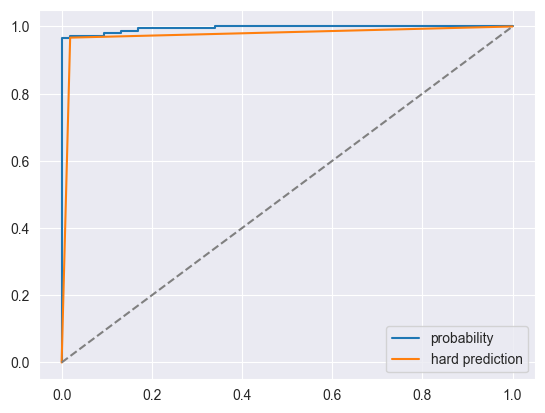

In [231]:
# Inspecting the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')
fpr, tpr, _ = roc_curve(y_val, y_pred_score)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

In [232]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

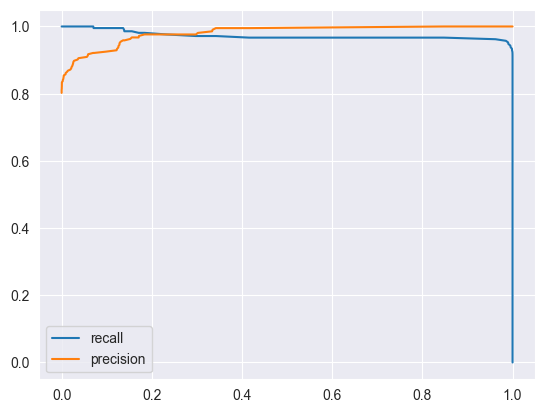

In [233]:
# Answer 3: 0.3
plt.plot(thresholds, recall[1:], label='recall')
plt.plot(thresholds, precision[1:], label='precision')
plt.legend()
plt.show()

In [234]:
def recall_precision_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, )
    scores = []
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)

        tp = (pred_positive & actual_positive).sum()
        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        scores.append((t, precision, recall))
    df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])
    df_scores['pr'] = df_scores.precision / df_scores.recall
    df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

    return df_scores

In [235]:
df_scores = recall_precision_dataframe(y_val, y_pred)
df_scores

,threshold,precision,recall,pr,f1
0,0.000000,0.799242,1.000000,0.799242,0.888421
1,0.020408,0.871901,1.000000,0.871901,0.931567
2,0.040816,0.905579,1.000000,0.905579,0.950450
3,0.061224,0.917391,1.000000,0.917391,0.956916
4,0.081633,0.921053,0.995261,0.925439,0.956720
5,0.102041,0.925110,0.995261,0.929515,0.958904
6,0.122449,0.929204,0.995261,0.933628,0.961098
7,0.142857,0.958525,0.985782,0.972350,0.971963
8,0.163265,0.967442,0.985782,0.981395,0.976526
9,0.183673,0.976415,0.981043,0.995283,0.978723


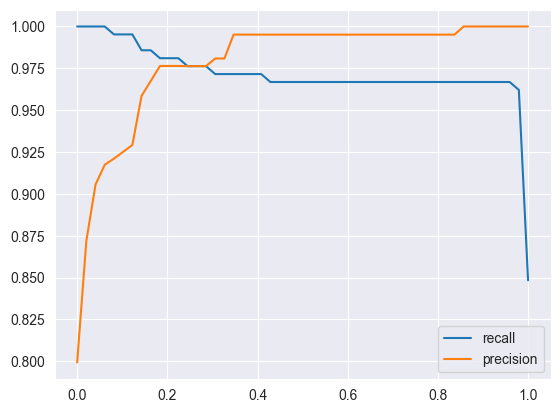

In [236]:
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.legend()
plt.show()


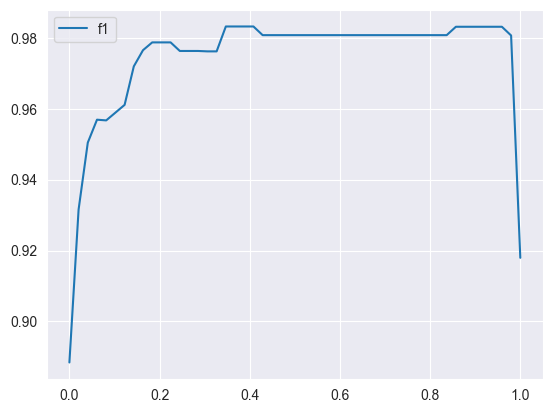

In [237]:
# Answer 4: 0.4
plt.plot(df_scores.threshold, df_scores.f1, label='f1')
plt.legend()
plt.show()


In [238]:
def train(df, y, c=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=c)
    model.fit(X_train, y)

    return dv, model

In [239]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [240]:
def kfold_scores(kfold, df_full_train, c):
    scores = []
    for train_idxs, val_idxs in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idxs]
        df_val = df_full_train.iloc[val_idxs]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    return scores

In [241]:
n_split = 5
kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)

In [242]:
#Answer 5: 0.003
scores = kfold_scores(kfold, df_full_train, 1)
print('%s -> %.3f +/- %.3f' % (1, np.mean(scores), np.std(scores)))


1 -> 0.996 +/- 0.003


In [243]:
# Answer 6: 1
for c in tqdm([0.01, 0.1, 1, 10]):
    scores = kfold_scores(kfold, df_full_train, c)
    print('%s -> %.3f +/- %.3f' % (c, np.mean(scores), np.std(scores)))


  0%|          | 0/4 [00:00<?, ?it/s]

0.01 -> 0.992 +/- 0.006
0.1 -> 0.995 +/- 0.004
1 -> 0.996 +/- 0.003
10 -> 0.996 +/- 0.003
